/tmp/ipykernel_3454121/2202446524.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')
/tmp/ipykernel_3454121/2202446524.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
/tmp/ipykernel_3454121/2202446524.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

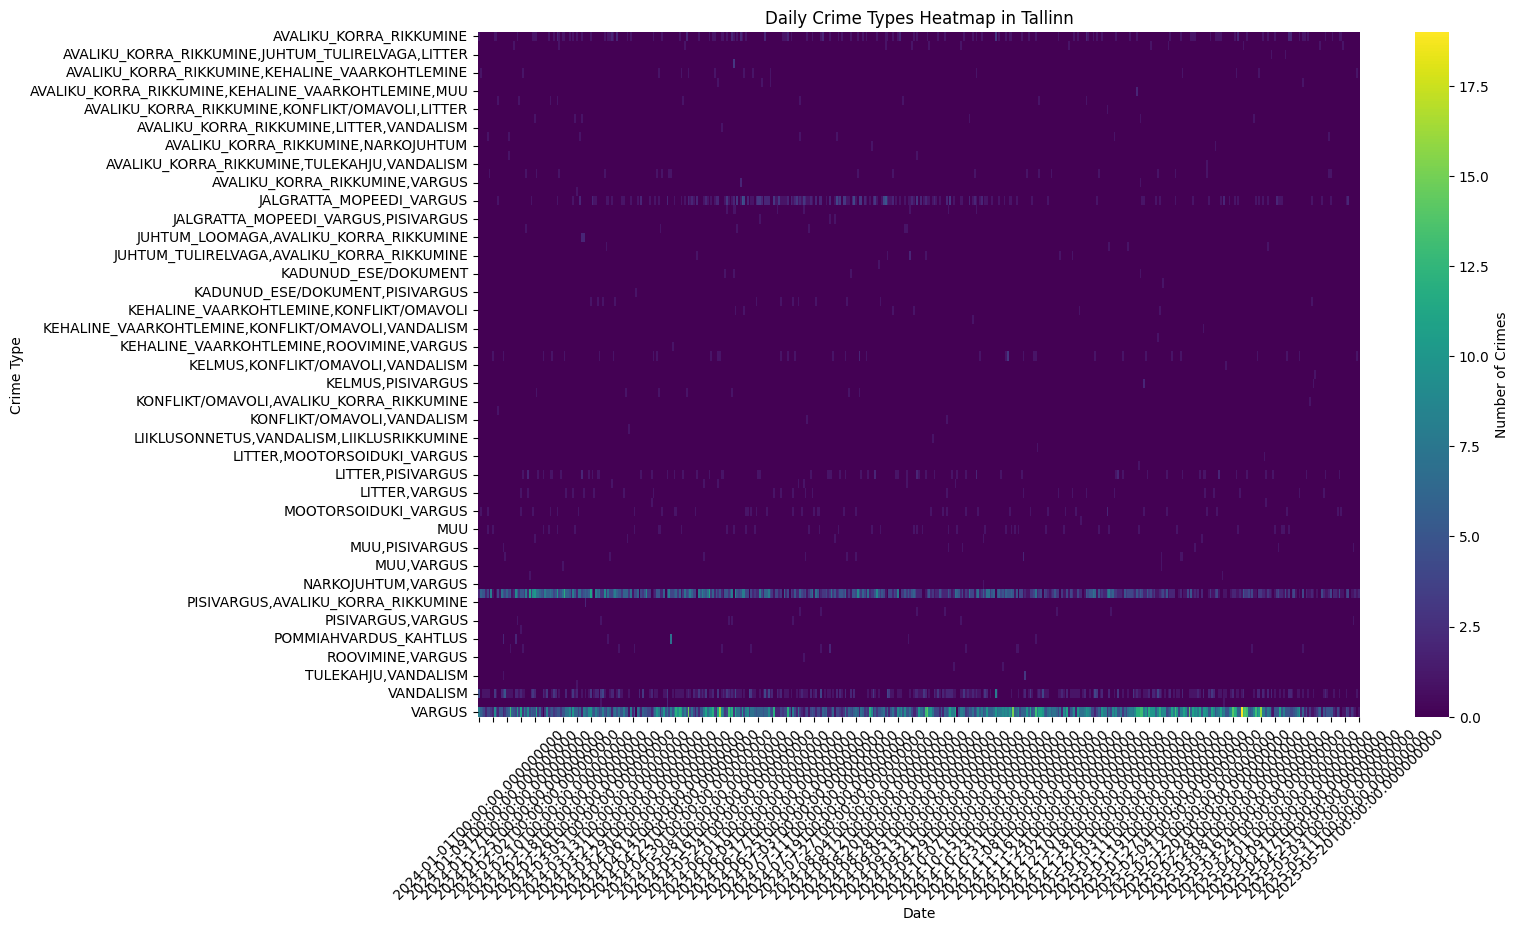

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "/home/maria/CrimeStats/data/avalik_1(1).csv"
dat = pd.read_csv(file_path, sep='\t')

# Filter for crimes in Tallinn
tallinn = dat[dat['ValdLinnNimetus'] == 'Tallinn']

# Parse the date and time columns
tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')
tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
tallinn['ToimKell'] = pd.to_timedelta(tallinn['ToimKell'] + ':00')

# Combine into a single datetime column
tallinn['ToimDatetime'] = tallinn['ToimKpv'] + tallinn['ToimKell']
tallinn = tallinn.dropna(subset=['ToimDatetime'])
tallinn.set_index('ToimDatetime', inplace=True)

# Get daily counts for each crime type
daily_crime_matrix = tallinn.groupby([pd.Grouper(freq='D'), 'SyndmusLiik']).size().unstack(fill_value=0)

# Sort columns alphabetically for consistency
daily_crime_matrix = daily_crime_matrix.sort_index(axis=1)

# Plot as heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(daily_crime_matrix.T, cmap="viridis", cbar_kws={'label': 'Number of Crimes'})
plt.title("Daily Crime Types Heatmap in Tallinn")
plt.xlabel("Date")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


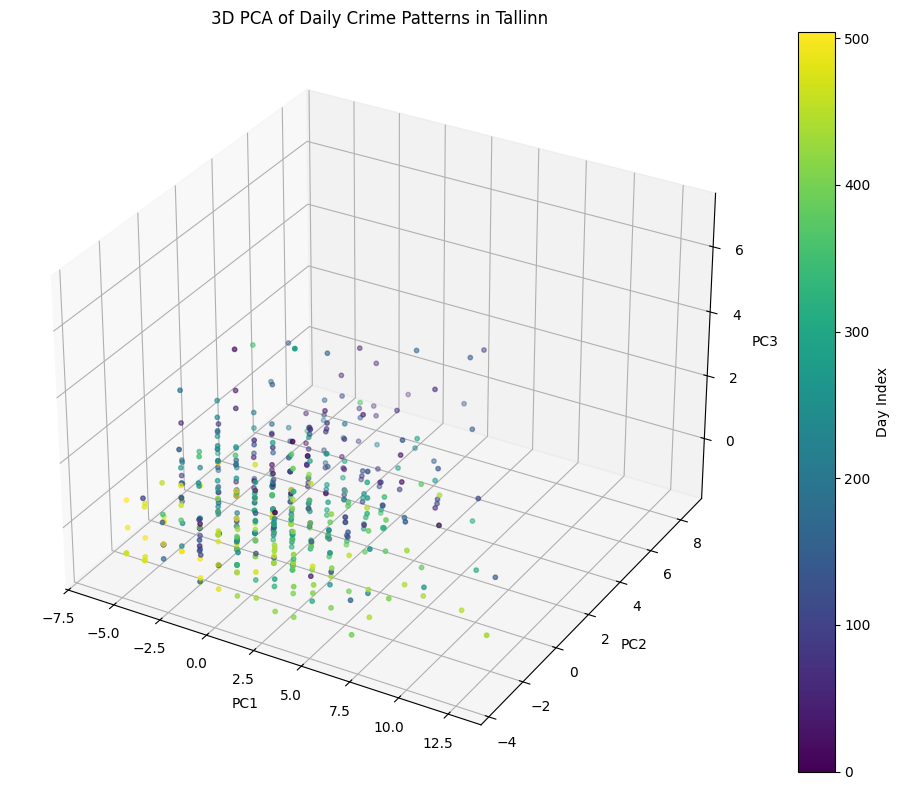

In [2]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Transpose so rows = days, columns = crime types
X = daily_crime_matrix.fillna(0).values  # shape (num_days, num_crime_types)

# Fit PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=range(X.shape[0]), cmap='viridis', s=10)

ax.set_title('3D PCA of Daily Crime Patterns in Tallinn')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.colorbar(sc, label='Day Index')
plt.tight_layout()
plt.show()


In [7]:
import plotly.express as px
import pandas as pd

# Assuming `X_pca` and `daily_crime_matrix` are already defined
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'], index=daily_crime_matrix.index)
pca_df['Date'] = pca_df.index

fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color=pca_df['Date'].astype(str),
    title='3D PCA of Daily Crime Patterns in Tallinn',
    labels={'color': 'Date'},
    opacity=0.7,
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()


In [9]:
# Add a normalized progression variable from 0 (earliest day) to 1 (latest day)
pca_df = pca_df.sort_values('Date')  # Make sure it's sorted chronologically
pca_df['Progress'] = (pca_df.index - pca_df.index.min()) / (pca_df.index.max() - pca_df.index.min())

# Plot with continuous color scale
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Progress',
    title='3D PCA of Daily Crime Patterns in Tallinn',
    labels={'color': 'Progression (0–1)'},
    opacity=0.7,
    color_continuous_scale='Plasma'  # Or Viridis, Plasma, Cividis etc.
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()


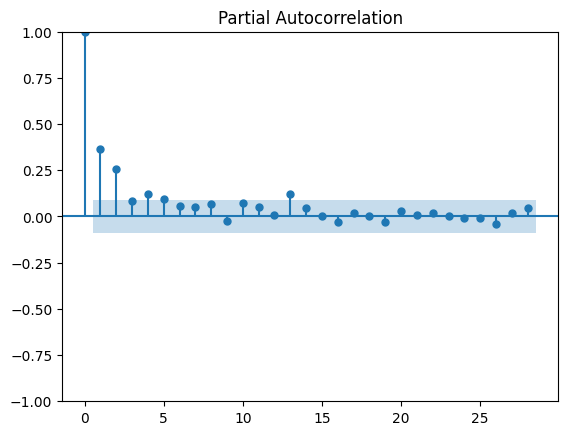

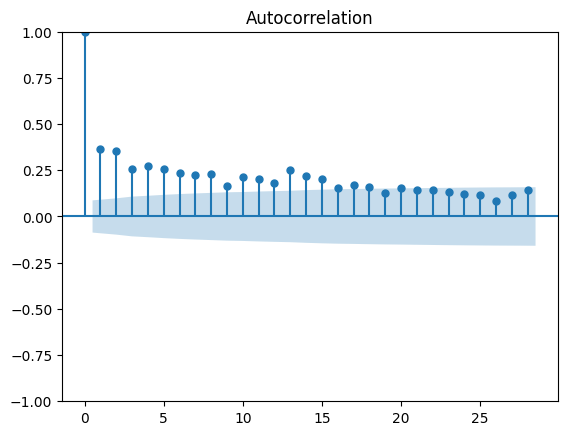

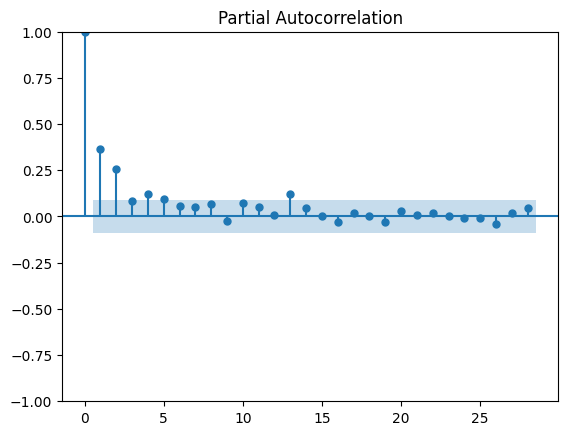

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Extract PC1 time series
pc1_series = pd.Series(X_pca[:, 0], index=daily_crime_matrix.index).sort_index()

# 1. Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(pc1_series.dropna())

plot_acf(pc1_series)
plot_pacf(pc1_series)

In [18]:
# 1. Get the explained variance ratio for the first component
explained_variance_pc1 = pca.explained_variance_ratio_[2]

# 2. Get the loadings (contributions of original variables to PC1)
pc1_loadings = pd.Series(pca.components_[2], index=daily_crime_matrix.columns)

# Sort by absolute magnitude to see most influential crime types
pc1_sorted = pc1_loadings.sort_values(key=abs, ascending=False)

# Display top contributors and explained variance
explained_variance_pc1, pc1_sorted.head(10)


(np.float64(0.05921428729976913),
 SyndmusLiik
 VANDALISM                                     0.982988
 JALGRATTA_MOPEEDI_VARGUS                      0.137087
 AVALIKU_KORRA_RIKKUMINE                       0.106051
 VARGUS                                       -0.033062
 MOOTORSOIDUKI_VARGUS                         -0.023713
 JALGRATTA_MOPEEDI_VARGUS,LITTER               0.017996
 AVALIKU_KORRA_RIKKUMINE,VANDALISM            -0.016052
 LITTER,PISIVARGUS                             0.014567
 VANDALISM,VARGUS                              0.011890
 AVALIKU_KORRA_RIKKUMINE,JUHTUM_TULIRELVAGA   -0.010382
 dtype: float64)

In [16]:
from sklearn.decomposition import NMF

# NMF requires non-negative input; the original daily_crime_matrix is already non-negative
# Fill any missing values just to be sure
nmf_input = daily_crime_matrix.fillna(0)

# Fit NMF with 3 components (same as PCA)
nmf_model = NMF(n_components=3, init='nndsvda', random_state=42)
W = nmf_model.fit_transform(nmf_input)  # shape: (days, components)
H = nmf_model.components_               # shape: (components, crime types)

# Explained variance is not directly available in NMF, but we can approximate reconstruction error
reconstruction = W @ H
reconstruction_error = ((nmf_input.values - reconstruction) ** 2).mean()

# Turn H into a DataFrame for interpretability
H_df = pd.DataFrame(H, columns=nmf_input.columns, index=[f'NMF{i+1}' for i in range(H.shape[0])])

# Show top contributing crime types to the first NMF component
nmf1_sorted = H_df.loc['NMF1'].sort_values(ascending=False)

reconstruction_error, nmf1_sorted.head(10)


(np.float64(0.02871445274999151),
 SyndmusLiik
 VARGUS                                             13.371029
 AVALIKU_KORRA_RIKKUMINE                             0.109098
 LITTER,VARGUS                                       0.093554
 KELMUS                                              0.075623
 MUU                                                 0.065138
 AVALIKU_KORRA_RIKKUMINE,VANDALISM                   0.064553
 LITTER,PISIVARGUS                                   0.059213
 MOOTORSOIDUKI_VARGUS                                0.054610
 AVALIKU_KORRA_RIKKUMINE,KEHALINE_VAARKOHTLEMINE     0.039162
 AVALIKU_KORRA_RIKKUMINE,JUHTUM_TULIRELVAGA          0.038649
 Name: NMF1, dtype: float64)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Extract PC1 time series
pc1_series = pd.Series(X_pca[:, 0], index=daily_crime_matrix.index).sort_index()

# 1. Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(pc1_series.dropna())

plot_acf(pc1_series)
plot_pacf(pc1_series)